## XGB Regression Experiments

## Load Dataset

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import random
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
from sklearn.metrics import f1_score
import optuna
from optuna.samplers import TPESampler
import joblib
from xgboost import XGBClassifier

In [4]:
random.seed(42)
np.random.seed(42)

- Load the train and test files 

In [6]:
train_df = pd.read_csv("train_data.csv")
val_df  = pd.read_csv("val_data.csv")
test_df  = pd.read_csv("test_data.csv")

In [7]:
print(f"Train: {len(train_df):>6} rows")
print(f" Val : {len(val_df):>6} rows")
print(f" Test: {len(test_df):>6} rows")

Train:   8000 rows
 Val :   1000 rows
 Test:   1000 rows


## Word2Vec - Experiment 3 (Word2Vec trained on SIA reviews)

In [9]:
def w2v_features(texts, vector_size, window, min_count, sg, epochs, workers):
    tok = texts.astype(str).apply(word_tokenize)
    model = Word2Vec(
      sentences   = tok.tolist(),
      vector_size = vector_size,
      window      = window,
      min_count   = min_count,
      sg          = sg,
      epochs      = epochs,
      workers     = workers,
      seed        = 42
    )
    # avg pooling
    def dv(toks):
        vecs = [model.wv[w] for w in toks if w in model.wv]
        return np.mean(vecs, axis=0) if vecs else np.zeros(vector_size)
    return np.vstack(tok.apply(dv).values), model

In [10]:
train_texts = train_df["text"].astype(str)
val_texts   = val_df["text"].astype(str)
y_train = train_df["sentiment_id"]
y_val   = val_df["sentiment_id"]

- Applying Optimal Parameters for Retraining and Evaluation on the Test Set

In [12]:
def objective(trial):
    # Word2Vec params
    vs = trial.suggest_int("vector_size", 100, 300, step=100)
    win   = trial.suggest_int("window", 3, 7)
    mc    = trial.suggest_int("min_count", 1, 10)
    sg    = trial.suggest_int("sg", 0, 1)       # 0=CBOW, 1=skip-gram
    epochs= trial.suggest_int("epochs",5,20)
    X_tr, w2v = w2v_features(train_texts, vs, win, mc, sg, epochs, workers=4)
    X_va      = np.vstack(val_texts.astype(str)
                          .apply(lambda d: np.mean(
                              [w2v.wv[w] for w in word_tokenize(d) if w in w2v.wv],
                              axis=0) if d else np.zeros(vs)
                          ).values)

    # --- XGBoost hyperparameters ---
    n_estimators     = trial.suggest_int("n_estimators", 50, 300)
    max_depth        = trial.suggest_int("max_depth", 3, 10)
    learning_rate    = trial.suggest_float("learning_rate", 0.01, 0.3)
    subsample        = trial.suggest_float("subsample", 0.6, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.6, 1.0)
    reg_alpha        = trial.suggest_float("reg_alpha", 0.0, 1.0)
    reg_lambda       = trial.suggest_float("reg_lambda", 0.0, 1.0)

    clf = XGBClassifier(
        objective        = "multi:softmax",  # or "binary:logistic" if binary
        num_class        = 3,                # adjust to your number of classes
        eval_metric      = "mlogloss",
        random_state     = 42,
        n_estimators     = n_estimators,
        max_depth        = max_depth,
        learning_rate    = learning_rate,
        subsample        = subsample,
        colsample_bytree = colsample_bytree,
        reg_alpha        = reg_alpha,
        reg_lambda       = reg_lambda
    )
    clf.fit(X_tr, y_train)
    preds = clf.predict(X_va)
    return f1_score(y_val, preds, average="macro")

In [13]:
sampler = TPESampler(seed=42, n_startup_trials=10)
study   = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=20)
print("Best macro-F1:", study.best_value)
print("Best hyperparameters:", study.best_params)

[I 2025-06-24 22:59:13,062] A new study created in memory with name: no-name-b7446b82-e320-4ef3-be23-8ade6f9a05ec
[I 2025-06-24 22:59:54,226] Trial 0 finished with value: 0.6345660389217558 and parameters: {'vector_size': 200, 'window': 7, 'min_count': 8, 'sg': 1, 'epochs': 7, 'n_estimators': 89, 'max_depth': 3, 'learning_rate': 0.2611910822747312, 'subsample': 0.8404460046972835, 'colsample_bytree': 0.8832290311184181, 'reg_alpha': 0.020584494295802447, 'reg_lambda': 0.9699098521619943}. Best is trial 0 with value: 0.6345660389217558.
[I 2025-06-24 23:00:52,813] Trial 1 finished with value: 0.5566652275755869 and parameters: {'vector_size': 300, 'window': 4, 'min_count': 2, 'sg': 0, 'epochs': 9, 'n_estimators': 181, 'max_depth': 6, 'learning_rate': 0.09445645065743215, 'subsample': 0.8447411578889518, 'colsample_bytree': 0.6557975442608167, 'reg_alpha': 0.29214464853521815, 'reg_lambda': 0.3663618432936917}. Best is trial 0 with value: 0.6345660389217558.
[I 2025-06-24 23:02:08,114] T

Best macro-F1: 0.6965525986818563
Best hyperparameters: {'vector_size': 300, 'window': 5, 'min_count': 7, 'sg': 1, 'epochs': 16, 'n_estimators': 208, 'max_depth': 4, 'learning_rate': 0.2992662502594824, 'subsample': 0.7588553432649746, 'colsample_bytree': 0.9224104398394748, 'reg_alpha': 0.6405301333656301, 'reg_lambda': 0.19603492887973462}


In [14]:
best = study.best_params
sentences = [word_tokenize(txt) for txt in train_df["text"].astype(str)]
w2v_final = Word2Vec(
    sentences   = sentences,
    vector_size = best["vector_size"],
    window      = best["window"],
    min_count   = best["min_count"],
    sg          = best["sg"],
    epochs      = best["epochs"],
    workers     = 4,
    seed        = 42
)

In [15]:
# average word2vec vectors for a document
def doc_vector(doc):
    toks = word_tokenize(str(doc))
    vecs = [w2v_final.wv[t] for t in toks if t in w2v_final.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(w2v_final.vector_size)

In [23]:
# Build feature matrices
X_train = np.vstack(train_texts.apply(doc_vector).values)
X_test  = np.vstack(test_df["text"].astype(str).apply(doc_vector).values)
y_train = train_df["sentiment_id"]
y_test  = test_df ["sentiment_id"]

In [24]:
from xgboost import XGBClassifier

In [25]:
clf_final = XGBClassifier(
    objective        = "multi:softmax",   
    num_class        = 3,                 # 3 class
    eval_metric      = "mlogloss",
    random_state     = 42,
    n_estimators     = best["n_estimators"],
    max_depth        = best["max_depth"],
    learning_rate    = best["learning_rate"],
    subsample        = best["subsample"],
    colsample_bytree = best["colsample_bytree"],
    reg_alpha        = best["reg_alpha"],
    reg_lambda       = best["reg_lambda"]
)
clf_final.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9224104398394748, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2992662502594824,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=208, n_jobs=None, num_class=3, ...)

In [26]:
y_test_pred = clf_final.predict(X_test)
print(classification_report(y_test,y_test_pred,target_names=["Negative", "Neutral", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.78      0.69      0.73       160
     Neutral       0.50      0.31      0.38       101
    Positive       0.90      0.97      0.93       739

    accuracy                           0.86      1000
   macro avg       0.73      0.66      0.68      1000
weighted avg       0.84      0.86      0.84      1000



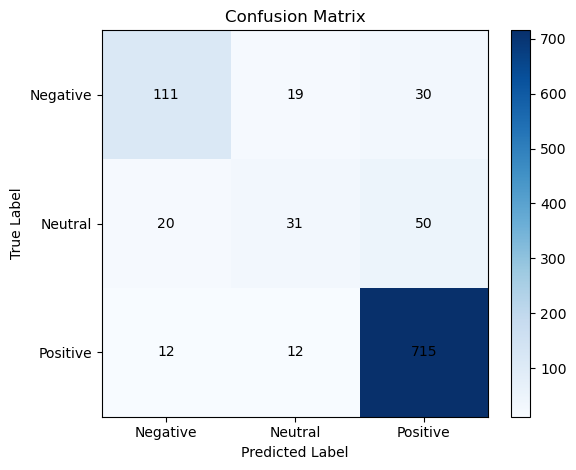

In [27]:
cm = confusion_matrix(test_df["sentiment_id"], y_test_pred)
labels = ["Negative", "Neutral", "Positive"]

fig, ax = plt.subplots()
im = ax.imshow(cm, cmap="Blues")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticks(np.arange(len(labels)))
ax.set_yticklabels(labels)
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_title("Confusion Matrix")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()

In [28]:
joblib.dump(clf_final, "XGB_word2vec_experiment3.pkl")

['XGB_word2vec_experiment3.pkl']